In [1]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import twint

In [4]:
import re
import string

In [5]:
import nest_asyncio

In [6]:
from nltk.corpus import stopwords

In [7]:
nest_asyncio.apply()

# Uncomment below cell!!!

In [8]:
# # Configure
# c = twint.Config()
# c.Username = "voguemagazine"
# c.Since = "2020-01-01"
# c.Until = "2020-07-01"
# c.Store_csv = True
# c.Output = "voguemagazine"

# # Run
# twint.run.Search(c)

In [9]:
#c

In [10]:
df_all_info_tweets = pd.read_csv('voguemagazine/tweets.csv')

In [11]:
df_all_info_tweets

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1277748739491454977,1277748739491454977,2020-06-29 16:40:13 PDT,2020-06-29,16:40:13,-800,136361303,voguemagazine,Vogue Magazine,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1277741076506427392,1277741076506427392,2020-06-29 16:09:46 PDT,2020-06-29,16:09:46,-800,136361303,voguemagazine,Vogue Magazine,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1277735264606195712,1277735264606195712,2020-06-29 15:46:40 PDT,2020-06-29,15:46:40,-800,136361303,voguemagazine,Vogue Magazine,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1277728986907455489,1277728986907455489,2020-06-29 15:21:44 PDT,2020-06-29,15:21:44,-800,136361303,voguemagazine,Vogue Magazine,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1277721201675309056,1277721201675309056,2020-06-29 14:50:48 PDT,2020-06-29,14:50:48,-800,136361303,voguemagazine,Vogue Magazine,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9445,1212199987012153345,1212199987012153345,2019-12-31 18:32:53 PST,2019-12-31,18:32:53,-800,136361303,voguemagazine,Vogue Magazine,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
9446,1212192155973902337,1212192155973902337,2019-12-31 18:01:46 PST,2019-12-31,18:01:46,-800,136361303,voguemagazine,Vogue Magazine,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
9447,1212184513490640896,1212184513490640896,2019-12-31 17:31:23 PST,2019-12-31,17:31:23,-800,136361303,voguemagazine,Vogue Magazine,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
9448,1212176343871475712,1212176343871475712,2019-12-31 16:58:56 PST,2019-12-31,16:58:56,-800,136361303,voguemagazine,Vogue Magazine,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


## Data cleaning

In [12]:
df_all_info_tweets.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [13]:
# copy of database with date and tweet
df= df_all_info_tweets.loc[:,['date', 'tweet']]

In [14]:
df.tweet.iloc[0] 

'If you’re looking to revamp your yoga or home-workout routine, Vogue Beauty editor @akiliking_ shares why she considers this the perfect mat.  https://t.co/OF9EkbSizw'

Tweet has link at the end, I'll delete it

In [15]:
for i, tweet in enumerate(df['tweet']):
    df['tweet'].iloc[i] = tweet.rsplit(' ', 1)[0]

In [16]:
df.tweet.iloc[0]

'If you’re looking to revamp your yoga or home-workout routine, Vogue Beauty editor @akiliking_ shares why she considers this the perfect mat. '

## Text preprocessing and Document-Term Matrix

In [17]:
# New york to new_york
repl = lambda x: x.replace('new york', 'new_york').replace('fashion week', 'fashion_week')
#mwe_tokens = lambda x: x.map(mwe_tekenizer.tokenize(word_tokenize(x)))
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())


df['tweet'] = df.tweet.map(alphanumeric).map(punc_lower).map(repl)
df.head()

,date,tweet
0,2020-06-29,if you’re looking to revamp your yoga or home ...
1,2020-06-29,from soothing meditations to supplements and t...
2,2020-06-29,warriors in the garden’s warriorsitg livia ...
3,2020-06-29,fast fashion may be getting cheaper while luxu...
4,2020-06-29,all of the apps classes and workouts that ca...


In [18]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"']
stop += ['http', 'https', 'co', 'see', 'ediitor', 'writer', 'vogue']
stop = set(stop)

## Playground below

In [19]:
# for tweet in df.tweet:
#     tweet.replace('new york', 'new_york')
#     tweet.replace('all of', 'all_of')

In [20]:
from nltk.tokenize import MWETokenizer #multi-word expression

In [21]:
from nltk.tokenize import word_tokenize

In [22]:
import nltk

In [23]:
mwe_tekenizer = MWETokenizer([('new', 'york')])

In [24]:
df_tok = df_all_info_tweets.loc[:,['date', 'tweet']]

In [25]:
tok = []
for el in df_tok.tweet:
    tok.append(mwe_tekenizer.tokenize(word_tokenize(el)))

In [26]:
w = mwe_tekenizer.tokenize(word_tokenize('new york ...'))
w

['new_york', '...']

In [27]:
mwe_tokens = mwe_tekenizer.tokenize(word_tokenize('new york ...'))

In [28]:
mwe_tokens

['new_york', '...']

In [29]:
q = re.sub('\w*\d\w*', ' ', 'dgsg 453 gdrg')
q

'dgsg   gdrg'

In [30]:
l1 = ['a', '2', 're']
s1= str(l1)
l1

['a', '2', 're']

## Playground above

In [31]:
X = df.tweet

In [32]:
X

0       if you’re looking to revamp your yoga or home ...
1       from soothing meditations to supplements and t...
2       warriors in the garden’s   warriorsitg  livia ...
3       fast fashion may be getting cheaper while luxu...
4       all of the apps  classes  and workouts that ca...
                              ...                        
9445    vogue staffers on the movies that affected the...
9446                                treat yourself in    
9447    in     dualipa had a breakout year not only wi...
9448    do you hate hearing recordings of yourself  yo...
9449    the best beauty products to stock up on in    ...
Name: tweet, Length: 9450, dtype: object

In [33]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams

vectorizer = CountVectorizer(stop_words=stop)

doc_word = vectorizer.fit_transform(X)

pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names()).head()

,aaronsorkin,ababa,abandoned,abba,abbey,abby,abdi,abe,aberfan,abetting,...,zoom,zoomtopia,zoë,zukin,zuri,zwirner,àcheval,álvarez,ísis,ýrúrarí
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
doc_word.shape

(9450, 11437)

In [35]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

## Non-Negative Matrix Factorization (NMF)

In [36]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(doc_word)

The W matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:
- Component 1 (topic 1) seems to be about pandemic in NY
- Component 2 (topic 2) seems to be about fashion and beauty

In [37]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             #index = ["component_1","component_2"],
             columns = vectorizer.get_feature_names())
topic_word

,aaronsorkin,ababa,abandoned,abba,abbey,abby,abdi,abe,aberfan,abetting,...,zoom,zoomtopia,zoë,zukin,zuri,zwirner,àcheval,álvarez,ísis,ýrúrarí
0,0.0,0.0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.01,...,0.057,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000
1,0.0,0.0,0.000,0.005,0.000,0.01,0.009,0.000,0.000,0.00,...,0.170,0.000,0.004,0.000,0.000,0.000,0.0,0.000,0.000,0.000
2,0.0,0.0,0.000,0.000,0.000,0.00,0.000,0.002,0.000,0.00,...,0.061,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.001
3,0.0,0.0,0.000,0.000,0.019,0.00,0.013,0.001,0.000,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000
4,0.0,0.0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000
5,0.0,0.0,0.000,0.000,0.000,0.00,0.000,0.001,0.000,0.00,...,0.000,0.000,0.015,0.000,0.011,0.000,0.0,0.000,0.000,0.000
6,0.0,0.0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,...,0.022,0.001,0.000,0.003,0.000,0.000,0.0,0.000,0.000,0.000
7,0.0,0.0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,...,0.101,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000
8,0.0,0.0,0.004,0.000,0.016,0.00,0.002,0.000,0.002,0.00,...,0.026,0.000,0.000,0.002,0.001,0.002,0.0,0.002,0.000,0.001
9,0.0,0.0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,...,0.035,0.000,0.000,0.000,0.002,0.000,0.0,0.000,0.096,0.000


In [38]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
new, series, need, year, netflix, collection, brand, video, book, women

Topic  1
one, editor, shares, life, help, zoom, two, men, dressing, game

Topic  2
best, oscars, shop, style, looks, women, face, season, winter, looking

Topic  3
fashion, brands, black, designers, show, owned, industry, years, favorite, always

Topic  4
red, carpet, oscars, goldenglobes, grammys, year, star, arrivals, sagawards, baftas

Topic  5
look, back, take, fall, show, style, get, paris, fashion_week, runway

Topic  6
time, black, self, care, lot, first, support, community, life, health

Topic  7
home, stay, make, work, go, perfect, editor, favorite, share, hair

Topic  8
like, world, us, day, year, new_york, says, coronavirus, love, life

Topic  9
beauty, shares, routine, makeup, watch, step, get, behind, skin, week


The H matrix shows us the documents we started with, and how each document is made up of the 2 resulting topics. In this case:
- The first document seems to be about pandemic in NY
- The last document seems to be about fashion and beauty
- Everything in between is a combination of the two

In [39]:
H = pd.DataFrame(doc_topic.round(5),
                 index = df.tweet
            # columns = ["component_1","component_2" ]
                )
H

,0,1,2,3,4,5,6,7,8,9
tweet,,,,,,,,,,
if you’re looking to revamp your yoga or home workout routine vogue beauty editor akiliking shares why she considers this the perfect mat,0.00000,0.05192,0.00183,0.00000,0.00000,0.0000,0.00000,0.25153,0.00000,0.30132
from soothing meditations to supplements and teas here are approaches to get a sounder night’s sleep,0.00035,0.00224,0.00526,0.00000,0.00204,0.0157,0.00152,0.00000,0.00792,0.03740
warriors in the garden’s warriorsitg livia rose johnson sees hair as an invaluable means of self expression,0.00264,0.00000,0.00282,0.00000,0.00181,0.0037,0.06269,0.01254,0.00000,0.01710
fast fashion may be getting cheaper while luxury gets more expensive–but it comes down to ethical labor fabric quality and profit margins,0.00000,0.00274,0.00044,0.18992,0.00000,0.0010,0.00331,0.00000,0.00461,0.00000
all of the apps classes and workouts that can help you maintain a super active lifestyle from home,0.00000,0.00106,0.00389,0.00051,0.00000,0.0000,0.00000,0.24033,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...
vogue staffers on the movies that affected them most this decade,0.00194,0.00039,0.00655,0.00459,0.00000,0.0000,0.00000,0.00000,0.00381,0.00000
treat yourself in,0.00020,0.00000,0.00020,0.00040,0.00000,0.0000,0.00017,0.00000,0.00000,0.00010
in dualipa had a breakout year not only with her music but also her style,0.00877,0.00352,0.01521,0.00160,0.01898,0.0134,0.00000,0.00000,0.06567,0.00000


## Non-Negative Matrix Factorization (NMF) Second version

In [40]:
vectorizer = CountVectorizer(stop_words = stop)
doc_word = vectorizer.fit_transform(df.tweet)
doc_word.shape

(9450, 11437)

In [41]:
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(doc_word)
doc_topic.shape

(9450, 2)

The **doc_topic** matrix shows us the documents we started with, and how each document is made up of the 2 resulting topics. We don't know yet what the topics are.

In [42]:
topic_word = nmf_model.components_
topic_word.shape

(2, 11437)

The **topic_word** matrix shows us the 2 resulting topics, and the terms that are associated with each topic. By looking at the words below, we an figure out what the topics are.

In [43]:
words = vectorizer.get_feature_names()
t = nmf_model.components_.argsort(axis=1)[:,-1:-7:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words

[['new', 'fashion', 'look', 'best', 'red', 'home'],
 ['one', 'editor', 'shares', 'time', 'life', 'like']]

In [44]:
topic_words

[['new', 'fashion', 'look', 'best', 'red', 'home'],
 ['one', 'editor', 'shares', 'time', 'life', 'like']]

In [45]:
doc_topic

array([[0.05537563, 0.09257097],
       [0.0171845 , 0.00534516],
       [0.0198864 , 0.00649842],
       ...,
       [0.04403375, 0.00395566],
       [0.00085917, 0.00046538],
       [0.07023282, 0.        ]])

In [46]:
doc_topic.argmax(axis=1)

array([1, 0, 0, ..., 0, 0, 0])

In [47]:
df['topic'] = doc_topic.argmax(axis=1)

In [48]:
df

,date,tweet,topic
0,2020-06-29,if you’re looking to revamp your yoga or home ...,1
1,2020-06-29,from soothing meditations to supplements and t...,0
2,2020-06-29,warriors in the garden’s warriorsitg livia ...,0
3,2020-06-29,fast fashion may be getting cheaper while luxu...,0
4,2020-06-29,all of the apps classes and workouts that ca...,0
...,...,...,...
9445,2019-12-31,vogue staffers on the movies that affected the...,0
9446,2019-12-31,treat yourself in,0
9447,2019-12-31,in dualipa had a breakout year not only wi...,0
9448,2019-12-31,do you hate hearing recordings of yourself yo...,0


In [49]:
from textblob import TextBlob

In [50]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [51]:
sid_obj = SentimentIntensityAnalyzer()
sentiment = []
for tweet in df.tweet:
    sentiment.append(sid_obj.polarity_scores(tweet))

In [52]:
sentiment

[{'neg': 0.0, 'neu': 0.673, 'pos': 0.327, 'compound': 0.8658},
 {'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'compound': 0.3818},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.763, 'pos': 0.237, 'compound': 0.7351},
 {'neg': 0.0, 'neu': 0.617, 'pos': 0.383, 'compound': 0.8519},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.919, 'pos': 0.081, 'compound': 0.4404},
 {'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'compound': 0.3612},
 {'neg': 0.042, 'neu': 0.637, 'pos': 0.32, 'compound': 0.9246},
 {'neg': 0.066, 'neu': 0.934, 'pos': 0.0, 'compound': -0.4019},
 {'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'compound': 0.7351},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.149, 'neu': 0.678, 'pos': 0.173, 'compound': 0.0649},
 {'neg': 0.181, 'neu': 0.778, 'pos': 0.041, 'compound': -0.7579},
 {'neg': 0.127, 'neu': 0.636, 'pos': 0.237, 'compound': 0.7184},
 {'neg': 0.087, 'neu': 0.851, 'pos': 0.062, 'compound': -0.0516},
 

In [53]:
pd.concat([df,pd.DataFrame(sentiment)], axis=1)

,date,tweet,topic,neg,neu,pos,compound
0,2020-06-29,if you’re looking to revamp your yoga or home ...,1,0.000,0.673,0.327,0.8658
1,2020-06-29,from soothing meditations to supplements and t...,0,0.000,0.795,0.205,0.3818
2,2020-06-29,warriors in the garden’s warriorsitg livia ...,0,0.000,1.000,0.000,0.0000
3,2020-06-29,fast fashion may be getting cheaper while luxu...,0,0.000,0.763,0.237,0.7351
4,2020-06-29,all of the apps classes and workouts that ca...,0,0.000,0.617,0.383,0.8519
...,...,...,...,...,...,...,...
9445,2019-12-31,vogue staffers on the movies that affected the...,0,0.138,0.862,0.000,-0.1531
9446,2019-12-31,treat yourself in,0,0.000,0.426,0.574,0.4019
9447,2019-12-31,in dualipa had a breakout year not only wi...,0,0.000,1.000,0.000,0.0000
9448,2019-12-31,do you hate hearing recordings of yourself yo...,0,0.256,0.623,0.120,-0.4515


## Latent Semantic Analysis (LSA)

In [54]:
type(doc_word)

scipy.sparse.csr.csr_matrix

In [55]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(2)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.00583502, 0.00833992])

The U matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:
- Component 1 (topic 1) seems to be about fashion
- Component 2 (topic 2) seems to be about entertainment

In [56]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2"],
             columns = vectorizer.get_feature_names())
topic_word

,aaronsorkin,ababa,abandoned,abba,abbey,abby,abdi,abe,aberfan,abetting,...,zoom,zoomtopia,zoë,zukin,zuri,zwirner,àcheval,álvarez,ísis,ýrúrarí
component_1,0.0,0.0,0.0,0.000,0.001,0.001,0.002,0.0,0.0,0.000,...,0.033,0.0,0.001,0.0,0.001,0.0,0.0,0.0,0.002,0.0
component_2,-0.0,-0.0,0.0,0.001,-0.000,0.002,0.001,-0.0,-0.0,-0.001,...,0.026,-0.0,0.000,0.0,-0.000,-0.0,-0.0,-0.0,0.001,-0.0


In [57]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
one, new, fashion, look, time, best, home, shares, like, editor

Topic  1
one, editor, shares, life, make, help, zoom, self, day, home


The Vt matrix shows us the documents we started with, and how each document is made up of the 2 resulting topics. In this case:
- The first four documents seem to be about sports
- The last three documents seem to be about music

In [58]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = X,
             columns = ["component_1","component_2" ])
Vt

,component_1,component_2
tweet,,
if you’re looking to revamp your yoga or home workout routine vogue beauty editor akiliking shares why she considers this the perfect mat,0.64471,0.26600
from soothing meditations to supplements and teas here are approaches to get a sounder night’s sleep,0.11667,-0.01655
warriors in the garden’s warriorsitg livia rose johnson sees hair as an invaluable means of self expression,0.13752,-0.01188
fast fashion may be getting cheaper while luxury gets more expensive–but it comes down to ethical labor fabric quality and profit margins,0.34470,-0.11370
all of the apps classes and workouts that can help you maintain a super active lifestyle from home,0.23283,0.04018
...,...,...
vogue staffers on the movies that affected them most this decade,0.02937,-0.01279
treat yourself in,0.00148,-0.00156
in dualipa had a breakout year not only with her music but also her style,0.26001,-0.11125


## PCA

In [59]:
from sklearn.decomposition import PCA

In [60]:
import numpy as np

In [61]:
ar = np.asarray(tok)

/Users/albinasitdikova/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [62]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=2)
pca.fit(tok)
pcafeatures_train = pca.transform(np.asarray(tok))

ValueError: setting an array element with a sequence.

## EDA

In [63]:
doc_word.shape

(9450, 11437)

In [64]:
df_EDA = pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names())

In [65]:
df_EDA['tweet_date']= df.date

In [66]:
df_EDA

,aaronsorkin,ababa,abandoned,abba,abbey,abby,abdi,abe,aberfan,abetting,...,zoomtopia,zoë,zukin,zuri,zwirner,àcheval,álvarez,ísis,ýrúrarí,tweet_date
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-06-29
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-06-29
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-06-29
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-06-29
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-06-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2019-12-31
9446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2019-12-31
9447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2019-12-31
9448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2019-12-31


In [67]:
import matplotlib.pyplot as plt

In [68]:
df2 = df_EDA.loc[:,['tweet_date', 'zoom']]

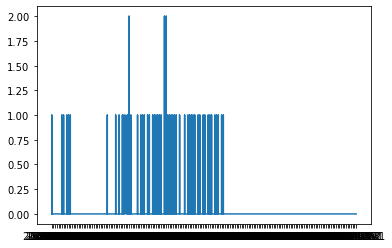

In [69]:
plt.plot(df_EDA['tweet_date'], df_EDA['zoom'])

In [70]:
# next create a new df that filters words daily
df3 = \
    (df2
     .groupby(['tweet_date'])[['tweet_date', 'zoom']]
     .sum()
     .reset_index())

In [71]:
df3

,tweet_date,zoom
0,2019-12-31,0
1,2020-01-01,0
2,2020-01-02,0
3,2020-01-03,0
4,2020-01-04,0
...,...,...
177,2020-06-25,0
178,2020-06-26,0
179,2020-06-27,0
180,2020-06-28,0


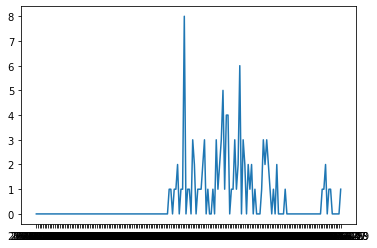

In [72]:
plt.plot(df3['tweet_date'], df3['zoom'])

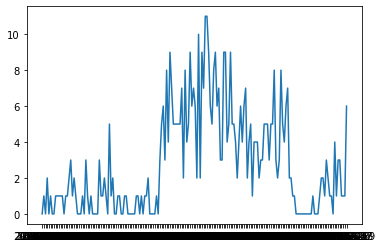

In [73]:
df4 = \
    (df_EDA
     .groupby(['tweet_date'])[['tweet_date', 'home']]
     .sum()
     .reset_index())

plt.plot(df4['tweet_date'], df4['home'])

In [74]:
df5 = \
    (df_EDA
     .groupby(['tweet_date'])
     .sum()
     .reset_index())

#plt.plot(df4['tweet_date'], df4['home'])

In [75]:
df5

,tweet_date,aaronsorkin,ababa,abandoned,abba,abbey,abby,abdi,abe,aberfan,...,zoom,zoomtopia,zoë,zukin,zuri,zwirner,àcheval,álvarez,ísis,ýrúrarí
0,2019-12-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2020-06-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178,2020-06-26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
179,2020-06-27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180,2020-06-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
df_words = df_EDA.copy()

In [95]:
df_words = df_words.drop(['tweet_date'], axis=1)

In [107]:
df_words

,aaronsorkin,ababa,abandoned,abba,abbey,abby,abdi,abe,aberfan,abetting,...,zoom,zoomtopia,zoë,zukin,zuri,zwirner,àcheval,álvarez,ísis,ýrúrarí
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
df6 = \
    (df_words
     .sum())

In [103]:
#df6 = df6.T

In [111]:
df6

aaronsorkin    1
ababa          1
abandoned      1
abba           1
abbey          3
              ..
zwirner        1
àcheval        1
álvarez        1
ísis           6
ýrúrarí        1
Length: 11437, dtype: int64

In [112]:
word_sorted = df6.sort_values(ascending=False)

In [113]:
word_sorted

one            768
new            749
fashion        579
best           575
look           566
              ... 
laggies          1
laguardia        1
lahijan          1
lak              1
aaronsorkin      1
Length: 11437, dtype: int64

In [104]:
df6.columns

RangeIndex(start=0, stop=11437, step=1)

In [106]:
df6.sort_values("0", ascending=False)

KeyError: '0'

## Visualisation

### WordCloud

In [76]:
from wordcloud import WordCloud, STOPWORDS 

In [77]:
topic_word.iloc[0]

aaronsorkin    0.000
ababa          0.000
abandoned      0.000
abba           0.000
abbey          0.001
               ...  
zwirner        0.000
àcheval        0.000
álvarez        0.000
ísis           0.002
ýrúrarí        0.000
Name: component_1, Length: 11437, dtype: float64

In [131]:
from PIL import Image

In [188]:
custom_mask = np.array(Image.open("q2.png"))

In [195]:
wordcloud = WordCloud(background_color="white", mask = custom_mask, stopwords=stop)
                      #, contour_width=1)
                      #, contour_color='black')
wordcloud.generate_from_frequencies(frequencies=word_sorted[:150])

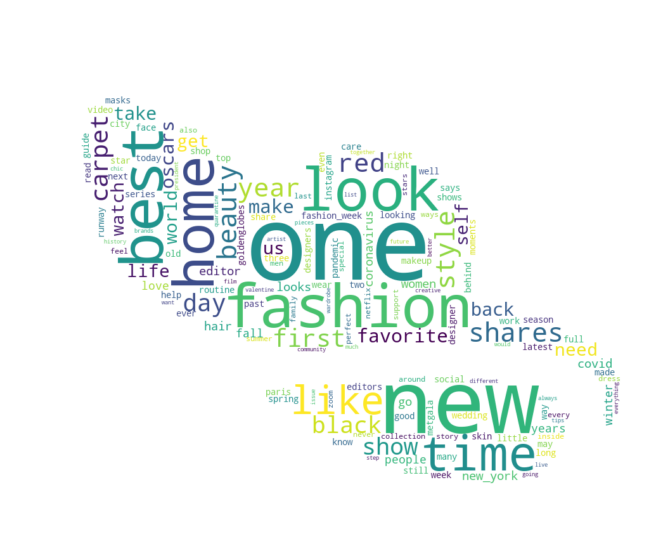

In [196]:
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
wc = WordCloud(background_color="white")
wc.generate(comment_words)

In [ ]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
plt.plot(topic_words[0].columns, topic_words[0])

In [ ]:
topic_words